In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

tickers = ['SPY', 'GLD', 'ILF', 'EMB' , 'EAGG.PA', 'AGG']  # S&P 500, Gold, Latam, emerging bonds, europe agregate, us aggregate 
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']

#Data cleaning 
# Check for missing values
missing_values = data.isna().sum(axis=0)

# Check for zero values
zero_values = (data == 0).sum(axis=0)



data.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /bbdd seleccion portafolio.xlsx', index=True)

[*********************100%***********************]  6 of 6 completed


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

data = pd.read_excel('/Users/matiasgonzalez/Desktop/Backtesting /bbdd seleccion portafolio.xlsx', index_col=0, parse_dates=True)
data = data.sort_index(ascending=True)
nombres = {'SPX Index': 'USA', 'MXEUG Index': 'Europa', 'UKX Index': 'UK', 'MXJP Index': 'Japon', 'MXASJ Index': 'Asia', 'MXLA Index': 'Latam', 'LF98TRUU Index': 'US HY', 'LUACTRUU Index': 'US IG', 'LBEATRUH Index': 'Europa', 'BSELTRUU Index': 'Latam corp', 'BSSUTRUU Index': 'Emerging sov', 'CABS Index': 'ABS', 'BCOMTR Index': 'Commodities'}
data = data.rename(columns=nombres)
data

,USA,Europa,UK,Japon,Asia,Latam,US HY,US IG,Europa,Latam corp,Emerging sov,ABS,Commodities
Dates,,,,,,,,,,,,,
2018-12-20,2472.0054,147.6143,8525.2742,8.1935,593.8972,2537.0861,1907.94,2826.69,280.50,926.6046,354.9825,208.357,163.9579
2018-12-21,2421.1110,146.4549,8511.4204,8.0358,592.8767,2530.6776,1904.43,2822.67,280.14,923.4961,354.3705,208.348,163.7316
2018-12-22,2421.1110,146.4549,8511.4204,8.0358,592.8767,2530.6776,1904.43,2822.67,280.14,923.4961,354.3705,208.348,163.7316
2018-12-23,2421.1110,146.4549,8511.4204,8.0358,592.8767,2530.6776,1904.43,2822.67,280.14,923.4961,354.3705,208.348,163.7316
2018-12-24,2355.6488,146.0293,8519.1220,8.0358,589.9852,2518.9476,1898.08,2826.86,280.28,924.2923,354.6248,208.801,160.6796
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,6490.5810,291.5918,14404.1569,13.2046,883.7019,3179.9814,2744.76,3331.99,308.09,1164.1589,415.7501,246.863,250.9966
2025-05-13,6537.7932,294.4683,14525.2860,13.4651,877.3902,3252.1550,2751.21,3333.91,307.80,1166.0031,416.5637,246.939,253.3514
2025-05-14,6544.7886,294.2373,14485.2319,13.5055,892.8963,3268.2043,2747.47,3323.98,307.59,1163.1910,416.0944,246.733,251.3217


<Figure size 1200x600 with 0 Axes>

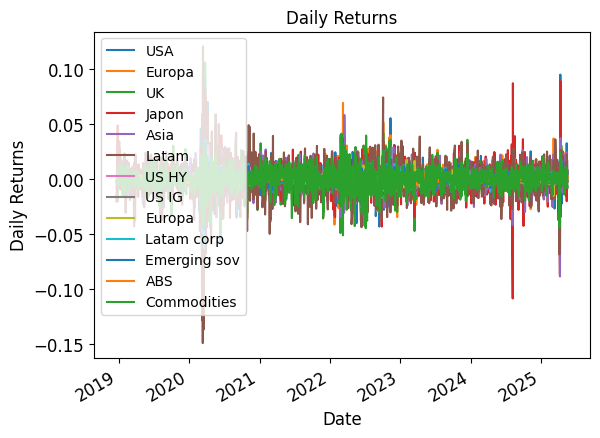

In [2]:
# Compute daily returns and drop rows with missing values
returns = data.pct_change().dropna(how="all")
#Eliminar valores cero
returns = returns[~(returns == 0).any(axis=1)]
plt.figure(figsize=(12, 6))
returns.plot(title="Daily Returns", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Returns", fontsize=12)
plt.legend(returns.columns, fontsize=10)
plt.show()
returns.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornosdf.xlsx', index=True)

In [3]:
# Calculate the covariance matrix
def port_var(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

#Calculate the risk contribution of each asset
def calculate_risk_contribution(weights, cov_matrix):
    portfolio_variance = port_var(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = np.multiply(weights, marginal_contrib) / portfolio_variance
    return risk_contrib

#Crear la función objetivo que disminuye la contribución de riesgo
def risk_parity_objective(weights, cov_matrix):
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)



In [4]:
def calculate_risk_parity_weights(returns):
    cov_matrix = returns.cov().values  # Convert to NumPy array
    n_assets = returns.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
        {'type': 'ineq', 'fun': lambda x: x}              # non-negative weights
    ]
    result = minimize(risk_parity_objective, 
                      initial_weights,
                      args=(cov_matrix,),
                      method='SLSQP',
                      constraints=constraints,
                      options={'ftol': 1e-12})
    return result.x

In [5]:

# Backtesting the strategy
from arch.bootstrap import StationaryBootstrap

def backtest_risk_parity(returns, lookback=252, rebalance_freq='ME'):
    portfolio_returns = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_risk_parity_weights(historical)

        period_return = np.sum(weights * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:])


portfolio_rp_results = backtest_risk_parity(returns)
print(portfolio_rp_results)
retorno_acum_rp = (1+portfolio_rp_results).cumprod()
retorno_acum_rp



Dates
2020-02-12    0.000764
2020-02-13    0.000128
2020-02-14    0.000785
2020-02-18   -0.000074
2020-02-19    0.000884
                ...   
2025-05-12    0.001255
2025-05-13    0.002582
2025-05-14   -0.000743
2025-05-15    0.001697
2025-05-16    0.000640
Length: 1213, dtype: float64


Dates
2020-02-12    1.000764
2020-02-13    1.000893
2020-02-14    1.001679
2020-02-18    1.001605
2020-02-19    1.002491
                ...   
2025-05-12    1.163698
2025-05-13    1.166702
2025-05-14    1.165836
2025-05-15    1.167814
2025-05-16    1.168562
Length: 1213, dtype: float64

In [6]:

#Equal weight strategy
def backtest_equal_weigth(returns, lookback=252, rebalance_freq='ME'):
    portfolio_returns = []
    n_assets = returns.shape[1]
    weights = np.array([1/n_assets] * n_assets)

    for date in returns.index[lookback:]:
        period_return = np.sum(weights * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:])

portfolio_ew_results = backtest_equal_weigth(returns)
print(portfolio_ew_results)
retorno_acum_ew = (1+portfolio_ew_results).cumprod()
retorno_acum_ew



Dates
2020-02-12    0.003017
2020-02-13   -0.000970
2020-02-14   -0.000072
2020-02-18   -0.002503
2020-02-19    0.002251
                ...   
2025-05-12    0.002398
2025-05-13    0.005850
2025-05-14    0.000441
2025-05-15    0.001403
2025-05-16    0.000184
Length: 1213, dtype: float64


Dates
2020-02-12    1.003017
2020-02-13    1.002044
2020-02-14    1.001972
2020-02-18    0.999464
2020-02-19    1.001714
                ...   
2025-05-12    1.223574
2025-05-13    1.230732
2025-05-14    1.231274
2025-05-15    1.233001
2025-05-16    1.233229
Length: 1213, dtype: float64

In [84]:
#Mean variance optimization strategy
import plotly.express as px
import seaborn as sns

#Instalar la librería de optimización de portafolios
#!pip3 install PyPortfolioOpt
import pypfopt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA


def calculate_mvo_weights(returns, risk_free_rate=0.000):
    mu = expected_returns.ema_historical_return(returns, returns_data=True, span=500)
    Sigma = risk_models.exp_cov(returns, returns_data=True, span=180)

    ef = EfficientFrontier(mu, Sigma)
    ef.max_sharpe(risk_free_rate=risk_free_rate)
    weights = list(ef.clean_weights().values())
    return weights




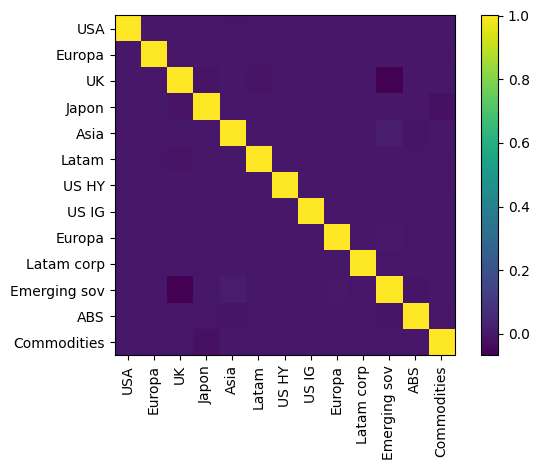

In [85]:
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier

#S = risk_models.sample_cov(returns, frequency=252)
# Plotting the covariance matrix
#plotting.plot_covariance(sample_cov, plot_correlation=True);

S = risk_models.CovarianceShrinkage(returns).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);
#def calculate_mvo_weights(returns):


In [198]:
asset_mapper = {
    'USA': 'Equity',	
    'Europa': 'Equity',	
    'UK': 'Equity',
    'Japon': 'Equity',
    'Asia': 'Equity',	
    'Latam': 'Equity',	
    'US HY': 'Bonds',	
    'US IG': 'Bonds',	
    'Europa': 'Bonds',	
    'Latam corp': 'Bonds',	
    'Emerging sov': 'Bonds',	
    'ABS': 'Bonds',	
    'Commodities': 'Commodities'
}

asset_lower = {
    "Equity": 0.0, # al menos 15% en equities
    "Bonds": 0.0, # al menos 15% en bonos
    "Commodities": 0.0 # No hay límite inferior para commodities
}

asset_upper = {
    "Equity": 1.0, # máximo 70% en equities
    "Bonds": 1.0, # máximo 70% en bonos
    "Commodities": 1.0 # máximo 20% en commodities
}


In [203]:
import cvxpy as cp

def calculate_mvo_weights(returns, risk_free_rate=0.0):
    mu = expected_returns.ema_historical_return(returns, returns_data=True, compounding=True, span=500, frequency=252, log_returns=False)
    #S = risk_models.sample_cov(returns, returns_data =True, frequency=252)
    S = risk_models.CovarianceShrinkage(returns, returns_data=True, frequency=252).ledoit_wolf()
        
    # Asegurar que al menos un rendimiento esperado sea mayor que la tasa libre de riesgo
   
    mu_adjusted = mu.copy()
    '''
    if all(m <= risk_free_rate for m in mu_adjusted):
        max_return_asset = mu_adjusted.idxmax()
        mu_adjusted[max_return_asset] = risk_free_rate + 0.001 # Añadir un pequeño margen
    '''
    
    '''
    if all(m <= risk_free_rate for m in mu_adjusted):
        min_return_asset = mu_adjusted.idxmin()
        risk_free_rate = mu_adjusted[min_return_asset] - 0.001 # disminuir un pequeño margen
    '''
        
    ef = EfficientFrontier(mu_adjusted, S, solver=cp.SCS) # weight_bounds automatically set to (0, 1)

    #ef = EfficientFrontier(mu, S)  
    #if any(m > risk_free_rate for m in mu[0:6]) & any(m > risk_free_rate for m in mu[7:12]):
     #   ef.add_sector_constraints(asset_mapper, asset_lower, asset_upper)

    ef.add_constraint(lambda w: cp.sum(w) == 1) # weights sum to 1

    #if all(m <= risk_free_rate for m in mu_adjusted):
     #   ef.add_constraint(lambda w: w[max_return_asset] == 1.0)
    #ef.add_constraint(lambda w: w[7] >= 0.05)

    ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    # Asegurarse de que los pesos sumen exactamente 1
    # Normalizar los pesos
    total_weight = sum(cleaned_weights.values())
    normalized_weights = {k: v/total_weight for k, v in cleaned_weights.items()}

    # Verificar
    print(f"Suma de pesos originales: {sum(cleaned_weights.values())}")
    print(f"Suma de pesos normalizados: {sum(normalized_weights.values())}")

    return normalized_weights

In [ ]:
def penalizacion_cardinalidad(w, umbral=0.02):
    n_activos = np.sum(w > umbral)
    return n_activos

def neg_sharpe_penalizado(w, mu, cov, lambd=2.5):
    port_return = np.dot(w, mu)
    #port_vol = port_var(w, cov) * 252
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(252)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    penal = penalizacion_cardinalidad(w) 
    penal = penal if sharpe > penal else 0
    return -sharpe + lambd * penal

def calculate_mvo_weights(returns): 
    mu = returns.mean(axis=0) * 252 # Annualized mean returns 
    cov = returns.cov().values

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x}  # non-negative weights
    ]
            
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu.values, cov), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 300}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [ ]:
def backtest_mvo(returns, lookback=252, rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_mvo_weights(historical)
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        print(f"Weights Series on {date}: {weights_series}")
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_mvo_results, weights_mvo = backtest_mvo(returns)
print(portfolio_mvo_results)
retorno_acum_mvo = (1+portfolio_mvo_results).cumprod()
print(retorno_acum_mvo)
retorno_acum_mvo.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_mvo.xlsx')
weights_mvo.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_mvo.xlsx')

Initial Weights: [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
Weights Series on 2020-02-12 00:00:00: USA             0.076910
Europa          0.018883
UK              0.018883
Japon           0.020000
Asia            0.018883
Latam           0.018883
US HY           0.208430
US IG           0.513058
Europa          0.027986
Latam corp      0.018883
Emerging sov    0.018883
ABS             0.021435
Commodities     0.018883
dtype: float64
Weights Series on 2020-02-13 00:00:00: USA             0.076910
Europa          0.018883
UK              0.018883
Japon           0.020000
Asia            0.018883
Latam           0.018883
US HY           0.208430
US IG           0.513058
Europa          0.027986
Latam corp      0.018883
Emerging sov    0.018883
ABS             0.021435
Commodities     0.018883
dtype: float64
Weights Series on 2020-02-14 00:00:00: USA             0.076910
Europa        

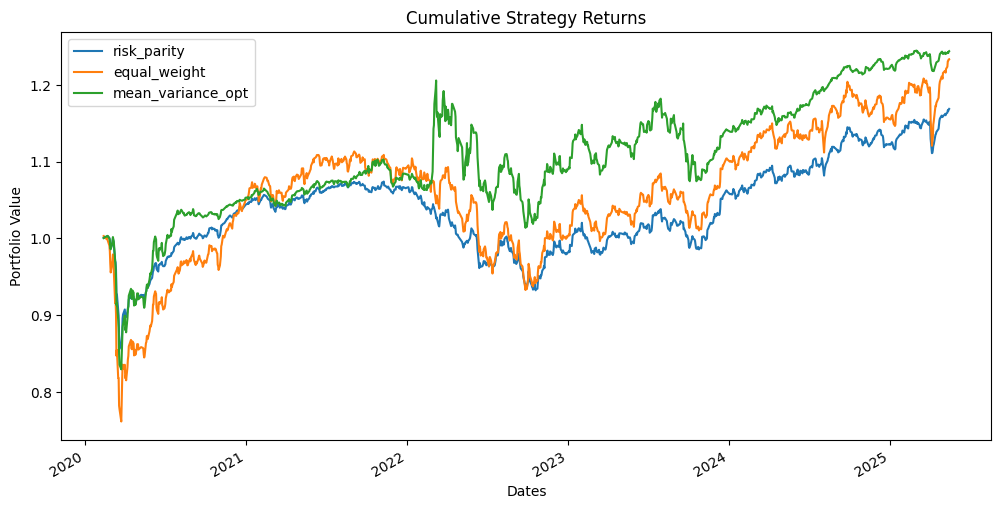

In [103]:

#Graficar los retornos de cada estrategia 
import matplotlib.pyplot as plt

returns_dict = {
    'risk_parity': portfolio_rp_results,
    'equal_weight': portfolio_ew_results,
    'mean_variance_opt': portfolio_mvo_results
}

def plot_strategy_comparison(returns_dict):
    cumulative_returns = pd.DataFrame({
        strategy: (1 + returns).cumprod() 
        for strategy, returns in returns_dict.items()
    })

    cumulative_returns.plot(figsize=(12, 6))
    plt.title('Cumulative Strategy Returns')
    plt.ylabel('Portfolio Value')
    plt.show()

plot_strategy_comparison(returns_dict)



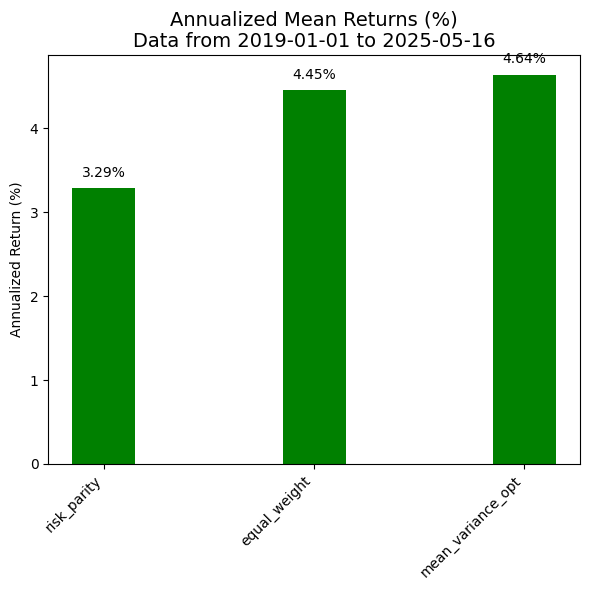

In [104]:
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

retorno_acum_rp = (((1 + portfolio_ew_results).cumprod().iloc[-1]) - 1) * 100
retorno_acum_rp

def plot_annualized_mean_returns(returns_dict):
    annualized_mean_returns_data = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1
        annualized_mean_returns_data[strategy] = annualized_return

    annualized_mean_returns = pd.Series(annualized_mean_returns_data)

    conditional_colors = ["green" if value > 0 else "red" for value in annualized_mean_returns]

    fig, ax = plt.subplots(figsize=(6, 6))

    bars = ax.bar(
        annualized_mean_returns.index,
        annualized_mean_returns * 100,  # Convert to percentage
        color=conditional_colors,
        width= 0.3
    );

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + np.sign(height) * 0.1,
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10
        );

    start_date = "2019-01-01"
    title_text = f"Annualized Mean Returns (%)\nData from {start_date} to {returns.index[-1].strftime('%Y-%m-%d')}"
    ax.set_title(title_text, fontsize=14);
    plt.xticks(rotation=45, ha='right');
    plt.ylabel("Annualized Return (%)");
    plt.tight_layout();
    plt.show()

plot_annualized_mean_returns(returns_dict)

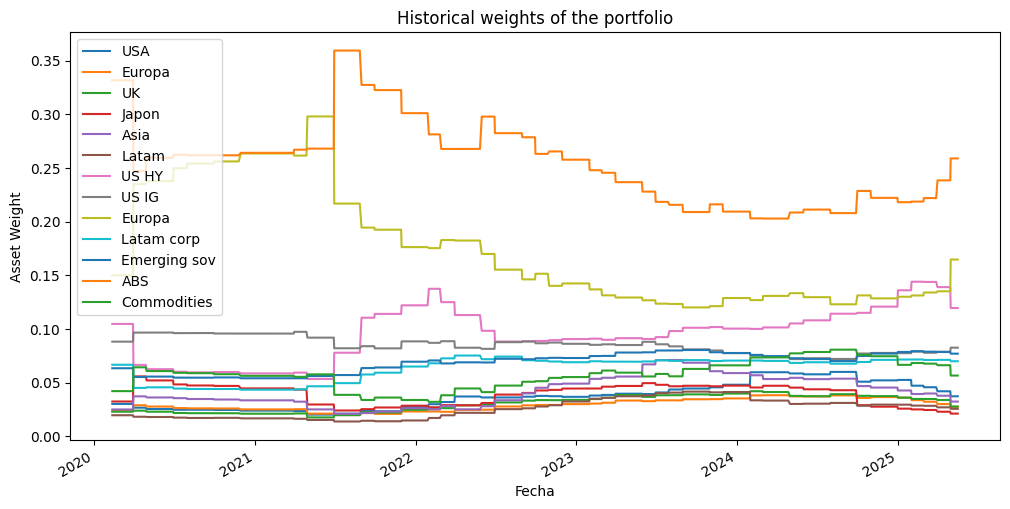

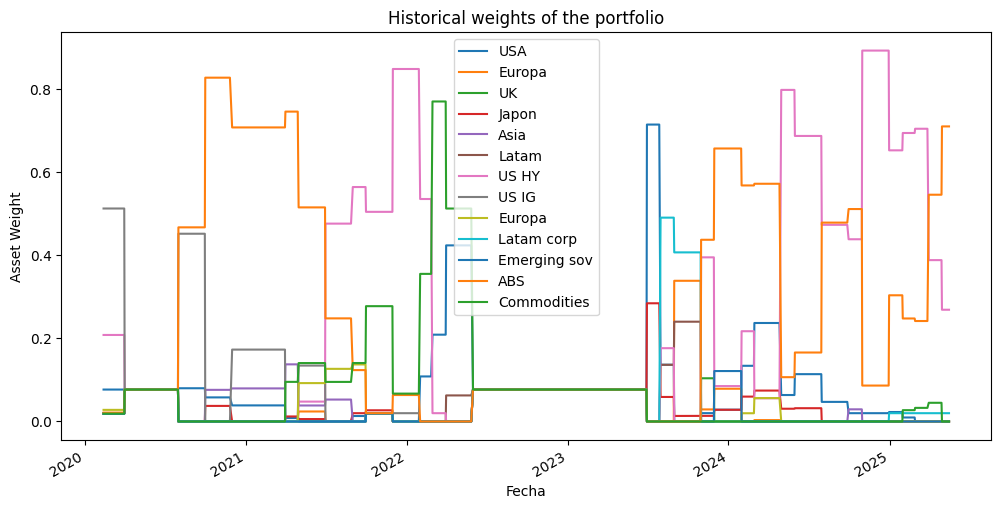

In [ ]:
#Graficar los pesos de cada activo en el portafolio por estrategia
def weights_rp_overtime(returns, lookback=252, rebalance_freq='ME'):
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_risk_parity_weights(historical)
        
        historical_weights.append(weights)
    return pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns)

historical_weights_rp = weights_rp_overtime(returns)

#graficar el peso de cada activo en el portafolio
def plot_weights(weights_df):  
    weights_df.plot(figsize=(12, 6))
    plt.title('Historical weights of the portfolio')
    plt.ylabel('Asset Weight')
    plt.xlabel('Fecha')
    plt.legend(weights_df.columns)
    plt.show()

plot_weights(historical_weights_rp)
plot_weights(weights_mvo)



<Figure size 1200x600 with 0 Axes>

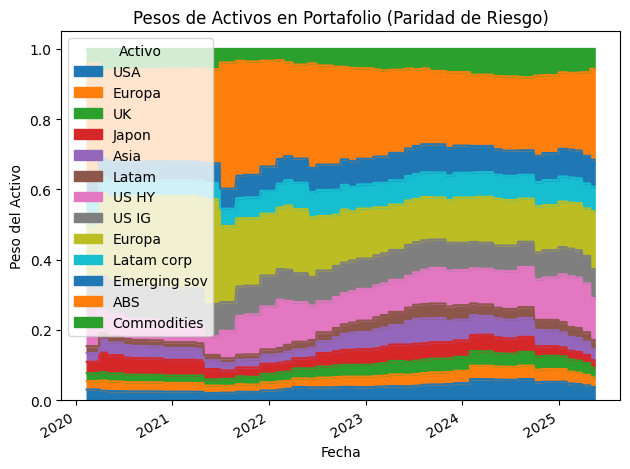

<Figure size 1200x600 with 0 Axes>

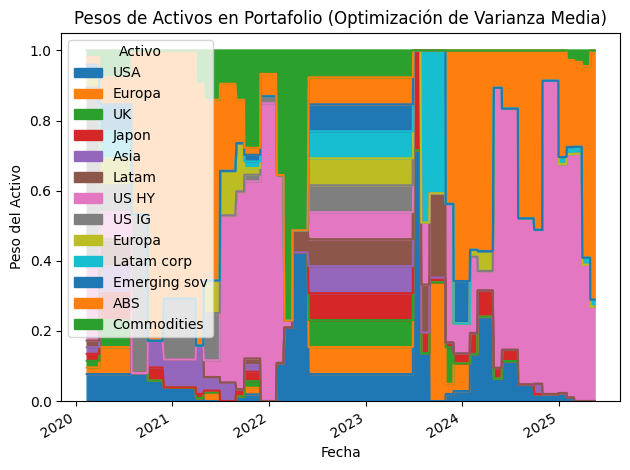

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que historical_weights_rp y historical_weights_mvo son DataFrames
# donde las columnas son los nombres de los activos y los valores son los pesos
# en cada fecha.

def plot_stacked_weights(weights_df, title):
    plt.figure(figsize=(12, 6))
    weights_df.plot.area(stacked=True)
    plt.title(title)
    plt.ylabel('Peso del Activo')
    plt.xlabel('Fecha')
    plt.legend(title='Activo')
    plt.tight_layout()
    plt.show()

# Graficar los pesos de la estrategia de Paridad de Riesgo como barras apiladas
plot_stacked_weights(historical_weights_rp, 'Pesos de Activos en Portafolio (Paridad de Riesgo)')

# Graficar los pesos de la estrategia de Optimización de Varianza Media como barras apiladas
plot_stacked_weights(weights_mvo, 'Pesos de Activos en Portafolio (Optimización de Varianza Media)')